# README

The focus of this code is to visualy show how the monoexponential and biexponential curves will be selected at a noise level

# Libraries

In [33]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import addcopyfighandler
import math
import time
from tqdm import trange
import sklearn
import colorsys
from datetime import date
from matplotlib.lines import Line2D


# Options

In [34]:
linear_TI = False            #Linear Linwidth for TI values?

# Initialization

In [35]:
######All Fixed parameters for code
#Parameters held constant
T11 = 600
T12 = 1200
c1 = 0.4
c2 = 0.6 
T21 = 40
T22 = 100

true_params = np.array([T11, T12, c1, c2, T21, T22])

SNR_value = 100

multi_starts_BIC = 5

#Building the TE array - this should be a uniform array
nTE = 64
dTE = 8

TE_DATA = np.linspace(dTE, dTE*nTE, nTE) #ms units

######### TI list of points used in the initial evaluation

TI_points = 30
TI_DATA_log = np.logspace(1, 3.5, TI_points)
TI_DATA_lin = np.linspace(10**1, 10**3.5, TI_points)

# Switch for TI list
if linear_TI:
    TI_DATA = TI_DATA_lin
    TI_blurb = f"linear ({TI_points} points)"
else:
    TI_DATA = TI_DATA_log
    TI_blurb = f"logarithmic ({TI_points} points)"

TI_DATA = np.array([0, 370, 385, 400, 415, 430, 820, 835, 850, 865, 880, 3*T12])#np.append(0,np.logspace(1,np.log10(3*T12),11))//1

#Preparing TI array to loop through
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

# Theoretical RSS coefficients
R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)

print(TI_DATA)

[   0  370  385  400  415  430  820  835  850  865  880 3600]


# Functions

In [36]:
#Defining the function of interest

def S_biX_6p(TE, T11, T12, c1, c2, T21, T22, TI = 0):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

#All curves get noise according to this equation
def add_noise(data, SNR):
    #returns a noised vector of data using the SNR given
    sigma = (c1+c2)/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

def BIC_opt1(RSS, n_array, n_params, sigma):

    BIC = 1/n_array * (RSS + np.log(n_array)*n_params*(sigma)**2)

    return BIC

def AIC(RSS, n_array, n_params, sigma):
    AIC = 1/n_array * (RSS + 2*n_params*(sigma)**2)

    return AIC

def int_lengh_AIC(R0, num_TE, diff_TE, SNR):
    return ((2*np.log(num_TE)-2)*diff_TE/(R0*SNR**2))**(1/2)


def int_lengh_opt1(R0, num_TE, diff_TE, SNR):
    return ((2*np.log(num_TE)-2)*diff_TE/(R0*SNR**2))**(1/2)

def int_lengh_opt2(R0, num_TE, diff_TE, SNR):
    return (diff_TE/(R0*SNR**2)*(num_TE**(2/num_TE)*(num_TE - 4) - (num_TE - 2)))**(1/2)

In [37]:
#The one dimensional models are used to evaluate if a curve is more likely monoX or biX
def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

def get_func_bounds(func):
    f_name = func.__name__
    if f_name == "S_biX_6p":
        lower_bound = (2, 2, 0, 0, 2, 2)
        upper_bound = (2000, 2000, 1, 1, 150, 150)
    elif f_name == "S_moX_3p":
        lower_bound = (2, 0, 2)
        upper_bound = (2000, 1, 150)
    elif f_name == "S_biX_4p":
        lower_bound = (-1, -1, 2, 2)
        upper_bound = (1, 1, 150, 150)
    elif f_name == "S_moX_2p":
        lower_bound = (-1, 2)
        upper_bound = (1, 150)
    else:
        raise Exception("Not a valid function: " + f_name)

    return lower_bound, upper_bound

def set_p0(func, random = True):
    true_params = [T11, T12, c1, c2, T21, T22]
    if random:
        lb, ub = get_func_bounds(func)
        if func.__name__.find("S_biX_6p") > -1:
            T11_est = np.random.uniform(lb[-6],ub[-6])
            T12_est = np.random.uniform(T11_est,ub[-5])
            c1_est = np.random.uniform(lb[-4],ub[-4])
            T21_est = np.random.uniform(lb[-2],ub[-2])
            T22_est = np.random.uniform(T21_est,ub[-1])
            p0 = [T11_est, T12_est, c1_est, 1-c1_est, T21_est, T22_est]
        else:
            p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        # f_name = func.__name__
        # if f_name.find("moX") > -1:
        #     p0 = [75, 0.5, 75]
        # elif f_name.find("biX") > -1:
        #     p0 = [75, 75, 0.5, 0.5, 75, 75]
        # else:
        p0 = true_params
            
    return p0

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def calculate_RSS(func, popt, data):
    est_curve = func(TE_DATA, *popt)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def estP_oneCurve(func, noisey_data):

    init_p = set_p0(func, random = True)
    lb, ub = get_func_bounds(func)

    popt, _ = curve_fit(func, TE_DATA, noisey_data, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
    popt = check_param_order(popt)
    RSS = calculate_RSS(func, popt, noisey_data)

    return popt, RSS

def evaluate_model(data, ms_iter = multi_starts_BIC):

    #Returns true if the moX is better than the biX --> returns a 1 for moX and a 0 for biX
    #Returns the parameters of the correct answer

    RSS_biX = np.inf
    RSS_moX = np.inf

    for ms in range(ms_iter):
        popt_biX_temp, RSS_biX_temp = estP_oneCurve(S_biX_4p, data)
        popt_moX_temp, RSS_moX_temp = estP_oneCurve(S_moX_2p, data)

        if RSS_biX_temp < RSS_biX:
            popt_biX = popt_biX_temp
            RSS_biX = RSS_biX_temp

        if RSS_moX_temp < RSS_moX:
            popt_moX = popt_moX_temp
            RSS_moX = RSS_moX_temp

    # popt_biX, RSS_biX = estP_oneCurve(S_biX_4p, data)
    # popt_moX, RSS_moX = estP_oneCurve(S_moX_2p, data)

    BIC_biX = BIC_opt1(RSS_biX, len(TE_DATA), len(popt_biX), 1/SNR_value)
    BIC_moX = BIC_opt1(RSS_moX, len(TE_DATA), len(popt_moX), 1/SNR_value)

    if BIC_moX < BIC_biX:
        return True, popt_moX, RSS_moX
    else:
        return False, popt_biX, RSS_biX

# Data Generation

In [38]:
all_data = np.zeros((TI_DATA.shape[0], TE_DATA.shape[0]))

for iTI in range(TI_DATA.shape[0]):
    all_data[iTI,:] = S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[iTI])

noised_data = add_noise(all_data, SNR_value)

In [39]:
nullpoint_curve1 = S_biX_6p(TE_DATA, *true_params, TI = TI1star)
nullpoint_curve2 = S_biX_6p(TE_DATA, *true_params, TI = TI2star)

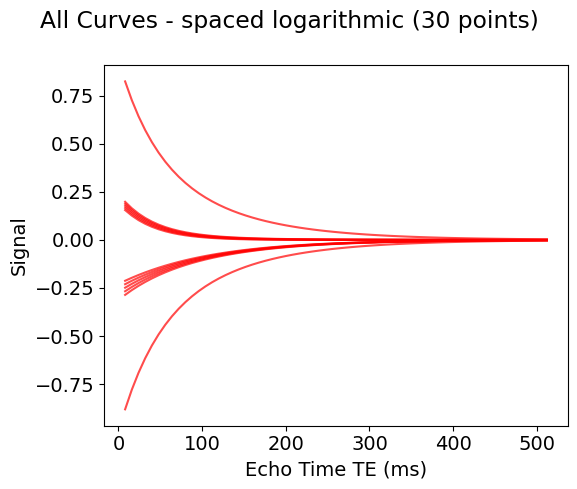

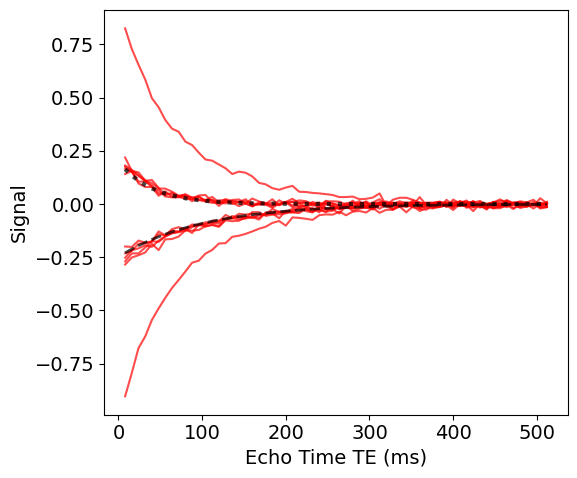

In [40]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
plt.rc('font', size = 14)
fig.suptitle(f'All Curves - spaced {TI_blurb}')

for iTI in range(TI_DATA.shape[0]):
    ax.plot(TE_DATA, all_data[iTI,:], alpha = 0.7, color = 'r')

ax.set_xlabel('Echo Time TE (ms)')
ax.set_ylabel('Signal')

plt.show()

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
plt.rc('font', size = 14)
# fig.suptitle(f'Noised Curves - spaced {TI_blurb}')

for iTI in range(TI_DATA.shape[0]):
    ax.plot(TE_DATA, noised_data[iTI,:], alpha = 0.7, color = 'r')

ax.set_xlabel('Echo Time TE (ms)')
ax.set_ylabel('Signal')
ax.plot(TE_DATA, nullpoint_curve1, alpha = 0.7, color = 'k', ls = '--', lw = 2)
ax.plot(TE_DATA, nullpoint_curve2, alpha = 0.7, color = 'k', ls = ':', lw = 3)

plt.show()

# Theoretical Noiseless Comparison

In [41]:
width_BIC_T1 = int_lengh_opt1(R0_coeff_TI1, nTE, dTE, SNR_value)
[low_BIC_TI1, high_BIC_TI1] = TI1star + [-width_BIC_T1, width_BIC_T1]

print([low_BIC_TI1, high_BIC_TI1])

width_BIC_T2 = int_lengh_opt1(R0_coeff_TI1, nTE, dTE, SNR_value)
[low_BIC_TI2, high_BIC_TI2] = TI2star + [-width_BIC_T2, width_BIC_T2]

print([low_BIC_TI2, high_BIC_TI2])

legend_elem = [Line2D([0], [0], color='r', lw=2, label='Biexponential'),
               Line2D([0], [0], color='g', lw=2, label='1st Monoexponential'),
               Line2D([0], [0], color='b', lw=2, label='2nd Monoexponential')]

[286.0638261118113, 545.712790560123]
[701.9521344477785, 961.6010988960902]


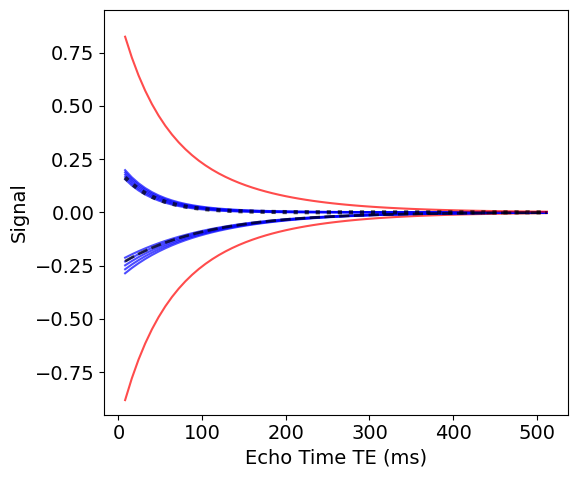

In [42]:


fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
# fig.suptitle(f'Noiseless Curves and Theoretical BIC Filter at SNR = {SNR_value}\nspaced {TI_blurb}')

for iTI in range(TI_DATA.shape[0]):
    TI_temp = TI_DATA[iTI]
    if TI_temp > low_BIC_TI1 and TI_temp < high_BIC_TI1:
        ax.plot(TE_DATA, all_data[iTI,:], alpha = 0.7, color = 'b')
    elif TI_temp > low_BIC_TI2 and TI_temp < high_BIC_TI2:
        ax.plot(TE_DATA, all_data[iTI,:], alpha = 0.7, color = 'b')
    else:
        ax.plot(TE_DATA, all_data[iTI,:], alpha = 0.7, color = 'r')

ax.plot(TE_DATA, nullpoint_curve1, alpha = 0.7, color = 'k', ls = '--', lw = 2)
ax.plot(TE_DATA, nullpoint_curve2, alpha = 0.7, color = 'k', ls = ':', lw = 3)
ax.set_xlabel('Echo Time TE (ms)')
ax.set_ylabel('Signal')
ax.set_ylim([-0.95, 0.95])
# ax.legend(handles=legend_elem, loc='upper right')

plt.show()

# Noised Curves with Theoretical Range

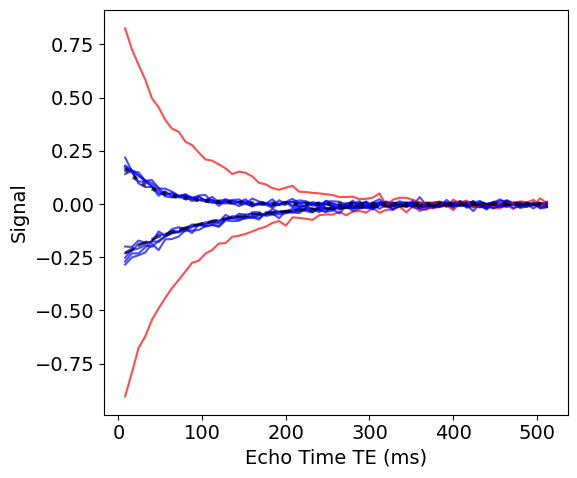

In [43]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
# fig.suptitle(f'Noised Curves and Theoretical BIC Filter at SNR = {SNR_value}\nspaced {TI_blurb}')

for iTI in range(TI_DATA.shape[0]):
    TI_temp = TI_DATA[iTI]
    if TI_temp > low_BIC_TI1 and TI_temp < high_BIC_TI1:
        ax.plot(TE_DATA, noised_data[iTI,:], alpha = 0.7, color = 'b')
    elif TI_temp > low_BIC_TI2 and TI_temp < high_BIC_TI2:
        ax.plot(TE_DATA, noised_data[iTI,:], alpha = 0.7, color = 'b')
    else:
        ax.plot(TE_DATA, noised_data[iTI,:], alpha = 0.7, color = 'r')

ax.set_xlabel('Echo Time TE (ms)')
ax.set_ylabel('Signal')
# ax.legend(handles=legend_elem, loc='upper right')
ax.plot(TE_DATA, nullpoint_curve1, alpha = 0.7, color = 'k', ls = '--', lw = 2)
ax.plot(TE_DATA, nullpoint_curve2, alpha = 0.7, color = 'k', ls = ':', lw = 3)

plt.show()

# Noised Curves with Experimental BIC Evaluation

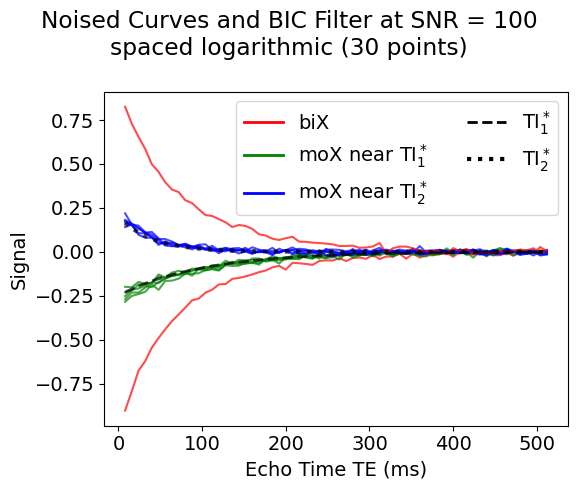

In [44]:
legend_elem = [Line2D([0], [0], color='r', lw=2, label='biX'),
               Line2D([0], [0], color='g', lw=2, label=r'moX near TI$_1^*$'),
               Line2D([0], [0], color='b', lw=2, label=r'moX near TI$_2^*$'),
               Line2D([0], [0], color='k', linewidth=2, linestyle='--', label=r'TI$_1^*$' ),
               Line2D([0], [0], color='k', linewidth=3, linestyle=':', label=r'TI$_2^*$')]

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
fig.suptitle(f'Noised Curves and BIC Filter at SNR = {SNR_value}\nspaced {TI_blurb}')

for iTI in range(TI_DATA.shape[0]):
    TI_temp = TI_DATA[iTI]
    moX_opt, _, _ = evaluate_model(noised_data[iTI, :])
    initSig = noised_data[iTI, 0]
    if initSig <0 and moX_opt:
        ax.plot(TE_DATA, noised_data[iTI,:], alpha = 0.7, color = 'g')
    elif initSig >0 and moX_opt:
        ax.plot(TE_DATA, noised_data[iTI,:], alpha = 0.7, color = 'b')
    else:
        ax.plot(TE_DATA, noised_data[iTI,:], alpha = 0.7, color = 'r')

ax.plot(TE_DATA, nullpoint_curve1, alpha = 0.7, color = 'k', ls = '--', lw = 2)
ax.plot(TE_DATA, nullpoint_curve2, alpha = 0.7, color = 'k', ls = ':', lw = 3)

ax.set_xlabel('Echo Time TE (ms)')
ax.set_ylabel('Signal')
ax.legend(handles=legend_elem, loc='upper right', ncol = 2)

plt.show()